# imports

In [1]:
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
sample_period_minutes = 10

In [3]:
df_short = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-20T03:59:00Z.csv')
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-26T03:59:00Z.csv')
df_short['time'] = pd.to_datetime(df_short['timestamp'],unit='s')
df['time'] = pd.to_datetime(df['timestamp'],unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close').resample(f'{sample_period_minutes}min').last()
df_short_close = df_short.pivot(index='time', columns='symbol', values='close').resample(f'{sample_period_minutes}min').last()

In [4]:
df_close.mean().sort_values()[-10:]

symbol
AUTOUSDT      234.063194
BNBUSDT       271.444444
BIFIUSDT      344.919444
MKRUSDT       646.109127
YFIIUSDT      881.950298
ETHUSDT      1321.425357
PAXGUSDT     1651.670635
YFIUSDT      8346.947421
WBTCBUSD    19033.746528
BTCUSDT     19033.803304
dtype: float64

In [5]:
symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
df_close_symbols = df_close[symbols]
df_short_close_symbols = df_short_close[symbols]

In [6]:
df_short_close_symbols

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,834.2,1300.92,1659.0,340.1,262.3
2022-09-19 04:10:00,834.6,1303.61,1659.0,340.1,262.3
2022-09-19 04:20:00,835.4,1303.85,1660.0,343.0,261.9
2022-09-19 04:30:00,835.0,1304.09,1659.0,341.3,261.3
2022-09-19 04:40:00,837.4,1305.19,1659.0,341.7,261.3
...,...,...,...,...,...
2022-09-20 03:10:00,879.8,1349.10,1666.0,345.6,268.2
2022-09-20 03:20:00,874.4,1344.29,1666.0,344.5,267.9
2022-09-20 03:30:00,879.8,1349.84,1667.0,344.6,268.6


In [7]:
df_close_symbols

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,834.2,1300.92,1659.0,340.1,262.3
2022-09-19 04:10:00,834.6,1303.61,1659.0,340.1,262.3
2022-09-19 04:20:00,835.4,1303.85,1660.0,343.0,261.9
2022-09-19 04:30:00,835.0,1304.09,1659.0,341.3,261.3
2022-09-19 04:40:00,837.4,1305.19,1659.0,341.7,261.3
...,...,...,...,...,...
2022-09-26 03:10:00,862.5,1306.53,1634.0,341.2,273.2
2022-09-26 03:20:00,863.4,1308.22,1633.0,340.9,273.4
2022-09-26 03:30:00,864.3,1307.04,1634.0,340.4,273.4


# Sanity check: eigen values, vectors

In [8]:
eiven_vals, eigen_vecs = np.linalg.eig([[1, 2, 0], [2, 1, 0], [0, 0, 4]])

In [9]:
eiven_vals

array([ 3., -1.,  4.])

In [10]:
eigen_vecs

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [55]:
eigen_vecs * np.sign(eigen_vecs[:,0][0])

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [11]:
eigen_vecs[:,0]

array([0.70710678, 0.70710678, 0.        ])

note that the matrix represenation is bit confusing. v[i,:] is *not* eigenvector, but v[:,i] is.

In [12]:
eigen_vecs[0]

array([ 0.70710678, -0.70710678,  0.        ])

and accordingly the eigenvalues matix on the rhs is to be horizontally layed down.

In [13]:
eigen_vecs @ np.diag(eiven_vals) @ eigen_vecs.T

array([[1., 2., 0.],
       [2., 1., 0.],
       [0., 0., 4.]])

# Solve the minimal predictability condition

In [14]:
df_short_close_symbols.corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
symbol,,,,,
YFIIUSDT,1.000000,0.950428,0.818159,0.932186,0.927611
ETHUSDT,0.950428,1.000000,0.921066,0.945962,0.968835
PAXGUSDT,0.818159,0.921066,1.000000,0.831618,0.920978
BIFIUSDT,0.932186,0.945962,0.831618,1.000000,0.939282
BNBUSDT,0.927611,0.968835,0.920978,0.939282,1.000000


In [15]:
df_close_symbols.corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
symbol,,,,,
YFIIUSDT,1.000000,0.141880,0.056761,0.511731,0.591847
ETHUSDT,0.141880,1.000000,0.244652,0.747294,0.232906
PAXGUSDT,0.056761,0.244652,1.000000,0.176519,-0.597424
BIFIUSDT,0.511731,0.747294,0.176519,1.000000,0.406546
BNBUSDT,0.591847,0.232906,-0.597424,0.406546,1.000000


the eigen_vecs are for calculation only, the actual distribution over the asset is returned in `wgts`.

In [16]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    return 1 / (m - lag - 1) * (arr[lag:] - np.nanmean(arr[lag:], axis=0)).T @ (arr[:m-lag] - np.nanmean(arr[:m-lag], axis=0))

In [71]:
def get_var1_wgts(df):
    #cov = df.cov()
    cov = np.cov(df.values.T)
    cov_inv = np.linalg.inv(cov)
    cov_inv_sqrt = scipy.linalg.sqrtm(cov_inv)
    autocov = calc_autocov_matrix(df.values, 1)
    #var_predictability = cov_inv_sqrt @ autocov @ cov @ autocov.T @ cov_inv_sqrt.T
    var_predictability = cov_inv_sqrt @ autocov @ cov_inv @ autocov.T @ cov_inv_sqrt.T

    var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability)

    asc = np.argsort(var_eigen_vals)
    var_eigen_vals, var_eigen_vecs = var_eigen_vals[asc], var_eigen_vecs[:, asc]
    var_eigen_vecs = var_eigen_vecs * np.sign(var_eigen_vecs[:,0][0])
    wgts = cov_inv_sqrt @ var_eigen_vecs
    if np.sign((df.values @ wgts[:,0])[0]) < 0:
        var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    return var_eigen_vals, var_eigen_vecs, wgts

In [72]:
np.sign(-5)

-1

The same function that takes df.values.T instead of df itself. This is used in the custom rolling function as the custom rolling function does not take the data frame but the arrays.

In [132]:
def get_var1_wgts_values_transpose(*df_values_T):
    cov = np.cov(df_values_T)
    cov_inv = np.linalg.inv(cov)
    cov_inv_sqrt = scipy.linalg.sqrtm(cov_inv)
    autocov = calc_autocov_matrix(np.transpose(df_values_T), 1)
    var_predictability = cov_inv_sqrt @ autocov @ cov @ autocov.T @ cov_inv_sqrt.T

    var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability)

    asc = np.argsort(var_eigen_vals)
    var_eigen_vals, var_eigen_vecs = var_eigen_vals[asc], var_eigen_vecs[:, asc]
    var_eigen_vecs = var_eigen_vecs * np.sign(var_eigen_vecs[:,0][0])
    wgts = cov_inv_sqrt @ var_eigen_vecs
    if np.sign((np.transpose(df_values_T) @ wgts[:,0])[-1]) < 0:
        pass # var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    if np.sign(wgts[-1,0]) < 0:
        var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    return var_eigen_vals, var_eigen_vecs, wgts

# Portfolio graphs

In [58]:
var_eigen_vals, var_eigen_vecs, wgts = get_var1_wgts(df_short_close_symbols)

In [59]:
var_eigen_vals, var_eigen_vecs, wgts = get_var1_wgts_values_transpose(*df_short_close_symbols.values.T)

In [60]:
var_eigen_vals

array([9.19895306e-02, 1.55701334e+00, 4.41433088e+00, 5.74653524e+02,
       1.64453118e+06])

In [23]:
print(var_eigen_vecs[:,0])
print(wgts[:,0])

[ 0.03770649 -0.09883495  0.39913313  0.6893261  -0.59525805]
[ 0.03343509 -0.06969227  0.44754502  0.70547717 -0.83054201]


In [24]:
print(var_eigen_vecs[:,-1])
print(wgts[:,-1])

[-0.46788481 -0.84519173 -0.1625215  -0.13208885 -0.15124167]
[-0.00512951 -0.02110584 -0.01660305 -0.01576956 -0.03117199]


## graphs

<Axes: xlabel='time'>

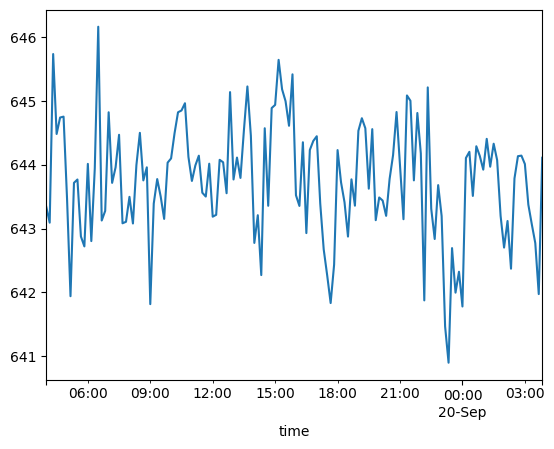

In [25]:
((df_short_close_symbols) * var_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

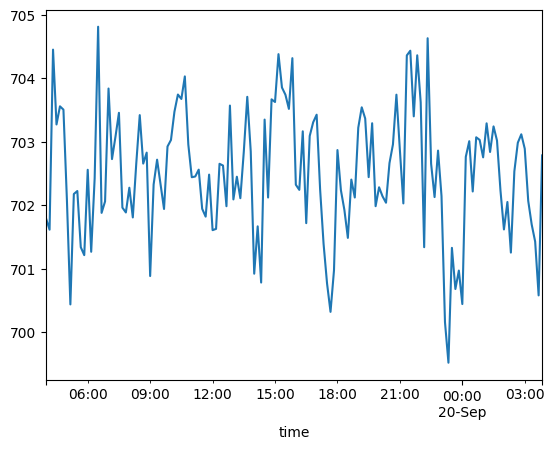

In [26]:
((df_short_close_symbols) * wgts[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

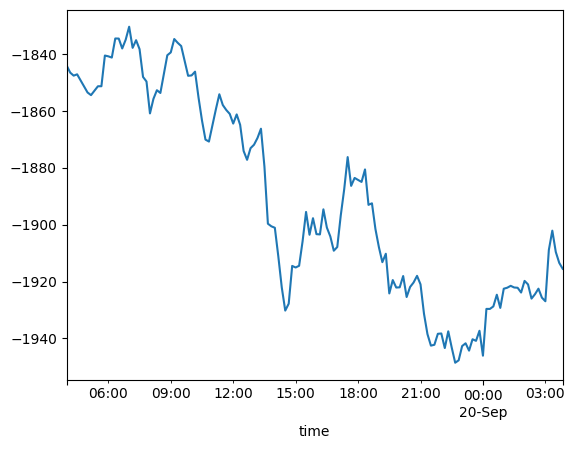

In [27]:
((df_short_close_symbols) * var_eigen_vecs[:,-1]).sum(axis=1).plot()

<Axes: xlabel='time'>

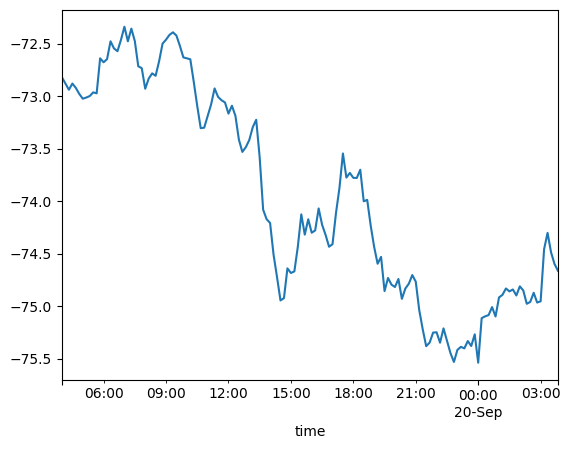

In [28]:
((df_short_close_symbols) * wgts[:,-1]).sum(axis=1).plot()

<Axes: xlabel='time'>

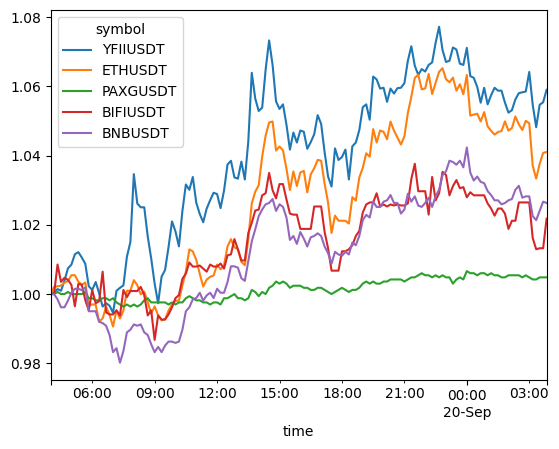

In [29]:
(df_short_close_symbols / df_short_close_symbols.iloc[0]).plot()

# rolling based

In [30]:
df_close_symbols.rolling(60).corr()

symbol                        YFIIUSDT   ETHUSDT  PAXGUSDT  BIFIUSDT   BNBUSDT
time                symbol                                                    
2022-09-19 04:00:00 YFIIUSDT       NaN       NaN       NaN       NaN       NaN
                    ETHUSDT        NaN       NaN       NaN       NaN       NaN
                    PAXGUSDT       NaN       NaN       NaN       NaN       NaN
                    BIFIUSDT       NaN       NaN       NaN       NaN       NaN
                    BNBUSDT        NaN       NaN       NaN       NaN       NaN
...                                ...       ...       ...       ...       ...
2022-09-26 03:50:00 YFIIUSDT  1.000000  0.141550  0.169061  0.807678  0.648751
                    ETHUSDT   0.141550  1.000000 -0.052298 -0.059383  0.433210
                    PAXGUSDT  0.169061 -0.052298  1.000000  0.320894  0.124574
                    BIFIUSDT  0.807678 -0.059383  0.320894  1.000000  0.552220
                    BNBUSDT   0.648751  0.433210  0.124574  0.552220  1.000000

[5040 rows x 5 columns]

In [146]:
def get_df_var1_eigenvecs_weights(df, window, step, order, if_evecs):
    '''
    order: 0 for the smallest eigen value, -1 for the largest.
    '''
    i = 1 if if_evecs else 2
    rolling_wgt = rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[i][:,order], window, *df.values.T)
    df_rolling_wgt = pd.DataFrame(rolling_wgt, index=df.index, columns=df.columns)
    df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{step * sample_period_minutes}min').first().resample(f'{sample_period_minutes}min').first().ffill()
    return df_rolling_wgt_resampled

In [137]:
def get_df_var1_eigenval(df, window, step):
    rolling_eval = rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[0][0], window, *df.values.T)
    df_rolling_eval = pd.DataFrame(rolling_eval, index=df.index, columns=["eigen_val"])
    df_rolling_eval_resampled = df_rolling_eval.resample(f'{step * sample_period_minutes}min').first().resample(f'{sample_period_minutes}min').first().ffill()
    return df_rolling_eval_resampled

<Axes: xlabel='time'>

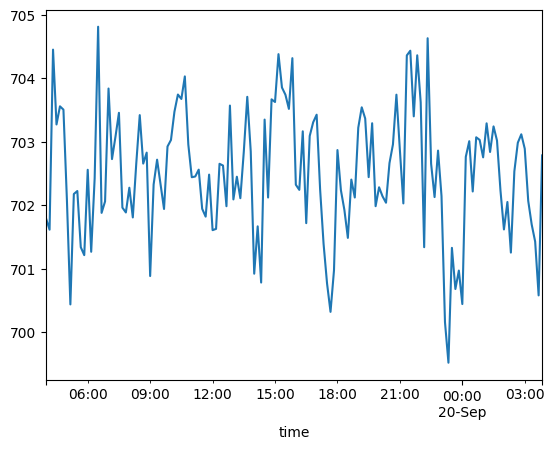

In [106]:
((df_short_close_symbols) * wgts[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

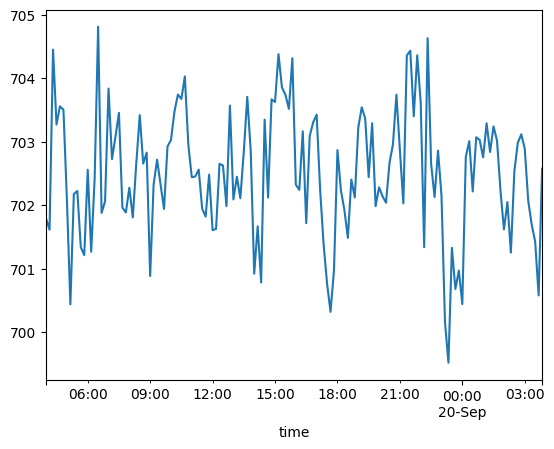

In [107]:
((df_close_symbols.iloc[:144]) * wgts[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

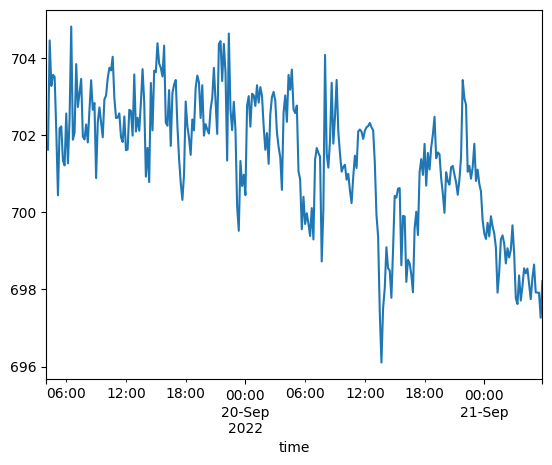

In [108]:
((df_close_symbols.iloc[:300]) * wgts[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

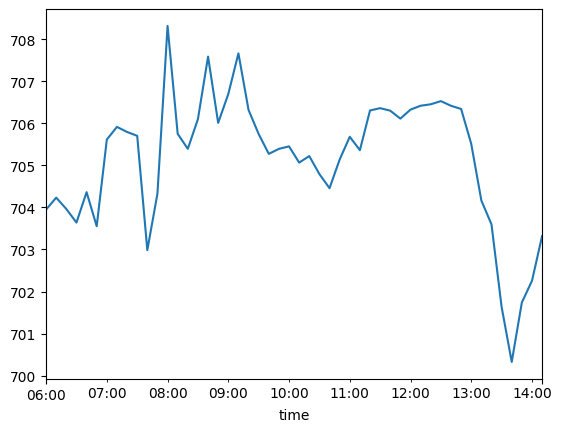

In [122]:
df = df_close_symbols.iloc[:300]
(df * get_df_var1_weights(df, 144, 80)).sum(axis=1).iloc[180:].iloc[:50].plot()

<Axes: xlabel='time'>

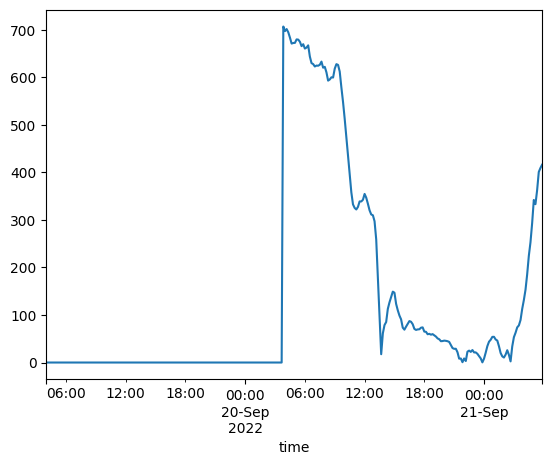

In [123]:
(df * get_df_var1_weights(df, 144, 1)).sum(axis=1).plot()

<Axes: xlabel='time'>

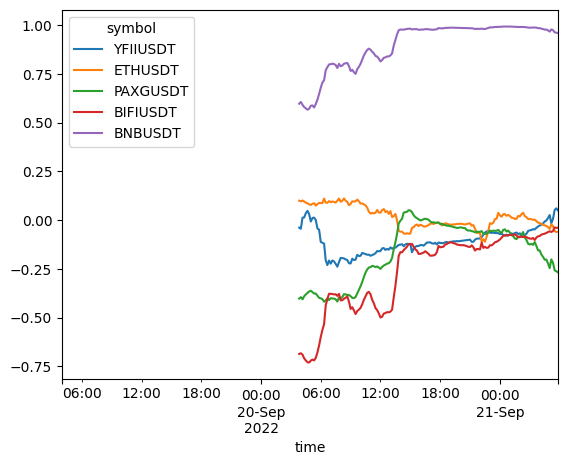

In [155]:
get_df_var1_eigenvecs_weights(df, 144, 1, 0, True).plot()

<Axes: xlabel='time'>

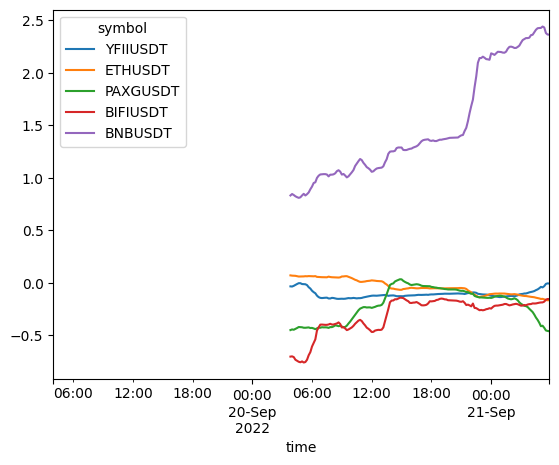

In [149]:
get_df_var1_eigenvecs_weights(df, 144, 1, 0, False).plot()

<Axes: xlabel='time'>

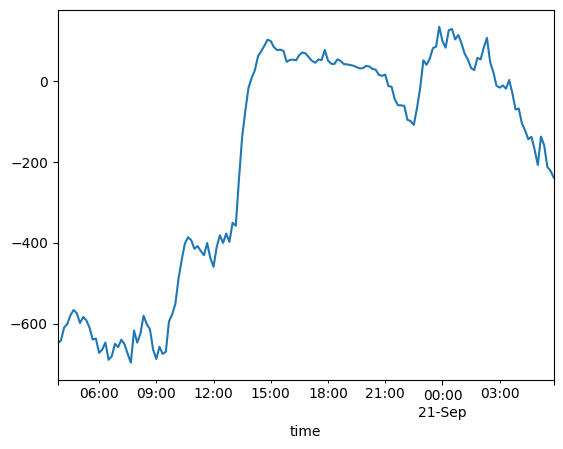

In [159]:
(df * get_df_var1_eigenvecs_weights(df, 144, 1, 0, True)).dropna().sum(axis=1).plot()

<Axes: xlabel='time'>

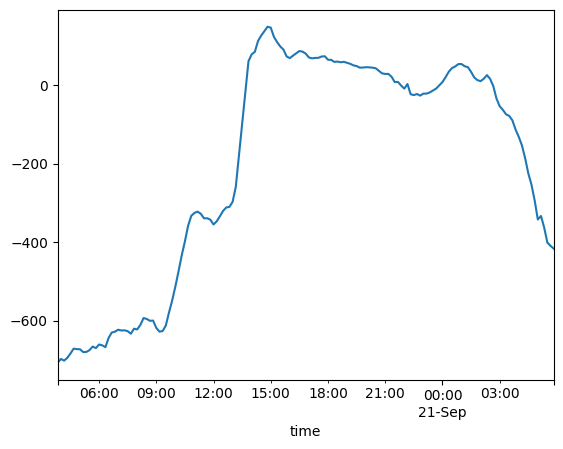

In [161]:
(df * get_df_var1_eigenvecs_weights(df, 144, 1, 0, False)).dropna().sum(axis=1).plot()

<Axes: xlabel='time'>

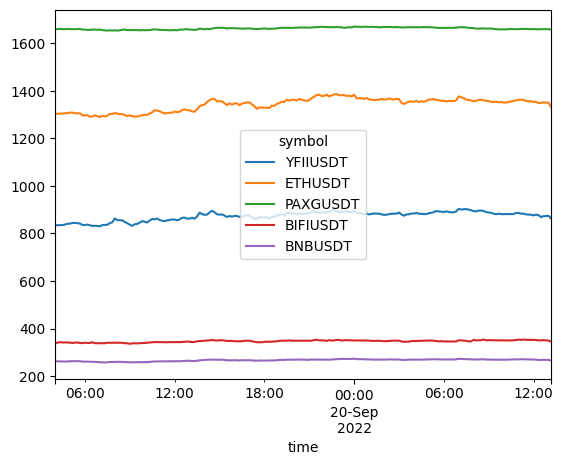

In [162]:
df_close_symbols.iloc[:200].plot()

In [46]:
get_df_var1_weights(df_short_close_symbols, 144, 1)

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:10:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:20:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:30:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:40:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-09-20 03:10:00,NaN,NaN,NaN,NaN,NaN
2022-09-20 03:20:00,NaN,NaN,NaN,NaN,NaN
2022-09-20 03:30:00,NaN,NaN,NaN,NaN,NaN


In [47]:
get_df_var1_weights(df_close_symbols, 144, 1).dropna()

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-20 03:50:00,0.034363,-0.070280,0.450692,0.703397,-0.831607
2022-09-20 04:00:00,0.035842,-0.067757,0.444484,0.701093,-0.845282
2022-09-20 04:10:00,0.029326,-0.067149,0.447423,0.708137,-0.835683
2022-09-20 04:20:00,0.020219,-0.066007,0.439261,0.733331,-0.823558
2022-09-20 04:30:00,0.011832,-0.062698,0.431112,0.743245,-0.815296
...,...,...,...,...,...
2022-09-26 03:10:00,0.184451,-0.122125,0.112906,-1.035369,1.243517
2022-09-26 03:20:00,0.179476,-0.116207,0.112631,-1.043597,1.222025
2022-09-26 03:30:00,0.178602,-0.114897,0.107441,-1.047902,1.219961


<Axes: xlabel='time'>

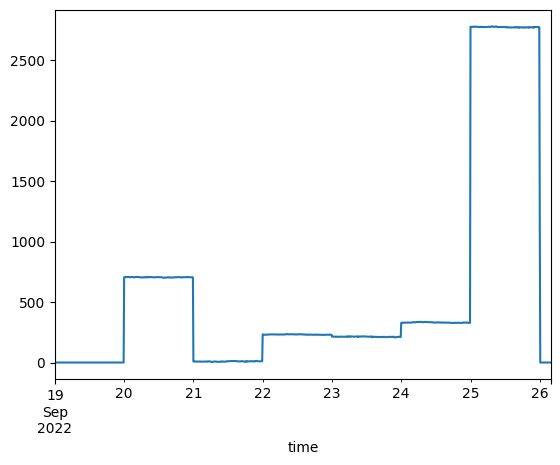

In [48]:
(get_df_var1_weights(df_close_symbols, 144, 144) * df_close_symbols).sum(axis=1).plot()

In [49]:
(get_df_var1_weights(df_close_symbols, 144, 144) * df_close_symbols).sum(axis=1)

time
2022-09-19 00:00:00    0.0
2022-09-19 00:10:00    0.0
2022-09-19 00:20:00    0.0
2022-09-19 00:30:00    0.0
2022-09-19 00:40:00    0.0
                      ... 
2022-09-26 03:10:00    0.0
2022-09-26 03:20:00    0.0
2022-09-26 03:30:00    0.0
2022-09-26 03:40:00    0.0
2022-09-26 03:50:00    0.0
Freq: 10T, Length: 1032, dtype: float64

In [50]:
df_rolling_wgt.dropna()

NameError: name 'df_rolling_wgt' is not defined

In [196]:
df_rolling_wgt_resampled.dropna()

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 13:40:00,0.029249,-0.098165,0.498413,0.869299,-0.861977
2022-09-19 13:50:00,0.029249,-0.098165,0.498413,0.869299,-0.861977
2022-09-19 14:00:00,-0.007469,0.046669,-0.431977,-0.862755,0.922017
2022-09-19 14:10:00,-0.007469,0.046669,-0.431977,-0.862755,0.922017
2022-09-19 14:20:00,0.029419,0.015596,-0.415113,-0.922855,0.957587
...,...,...,...,...,...
2022-09-20 03:00:00,-0.265921,0.045494,-0.052408,0.825063,-0.170705
2022-09-20 03:10:00,-0.265921,0.045494,-0.052408,0.825063,-0.170705
2022-09-20 03:20:00,-0.250653,0.036904,-0.034729,0.834697,-0.232567


In [166]:
pd.DataFrame(rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[2][:,0], 60, *df_close_symbols.values.T), index=df_close_symbols.index, columns=df_close_symbols.columns)

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:10:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:20:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:30:00,NaN,NaN,NaN,NaN,NaN
2022-09-19 04:40:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-09-20 03:10:00,-0.262658,0.048858,-0.070618,0.805512,-0.187553
2022-09-20 03:20:00,-0.250653,0.036904,-0.034729,0.834697,-0.232567
2022-09-20 03:30:00,-0.155232,-0.022996,0.134688,0.871342,-0.316391


<Axes: xlabel='time'>

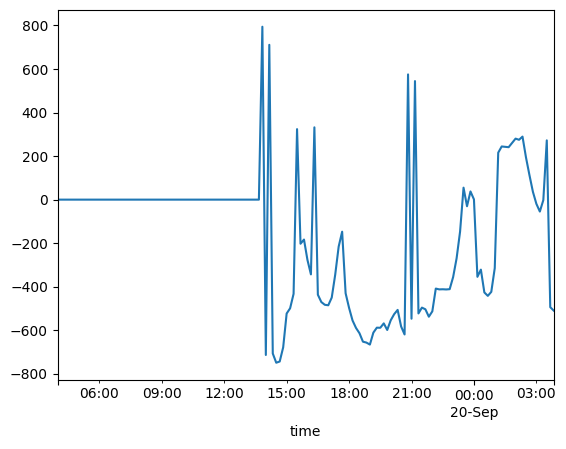

In [167]:
(pd.DataFrame(rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[2][:,0], 60, *df_close_symbols.values.T), index=df_close_symbols.index, columns=df_close_symbols.columns) * df_close_symbols).sum(axis=1).plot()